### Table of contents:

* [Investments](#investments)
* [Funding rounds](#fun_rounds)
* [Merge investments and funding rounds](#merge)
* [Graph](#graph)
* [Analysis](#analysis)
* [Update dictionaries](#update)

In [84]:
import math
import pandas as pd
import arrow
import ipynb 
import pickle
import os.path
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from dotenv import load_dotenv
from networkx.algorithms import bipartite
from importlib import reload

load_dotenv(verbose=True)


import pandas as pd
pd.options.mode.chained_assignment = None  

In [85]:
# import functions from py file 

import functions.fun
reload(functions.fun)
from functions.fun import CB_data_cleaning, df_from_api_CB, extract_nodes, extract_data_from_column
from functions.fun import nx_dip_graph_from_pandas, plot_bipartite_graph, filter_dict
from functions.fun import extract_classes_company_tech, degree_bip, insert_data_classes

In [86]:
# import classes 
import classes

## Investments <a class="anchor" id="investments"></a>

In [87]:
df_investments = pd.read_csv("data/data_cb/investments.csv")

In [88]:
df_investments.columns

Index(['uuid', 'name', 'type', 'permalink', 'cb_url', 'rank', 'created_at',
       'updated_at', 'funding_round_uuid', 'funding_round_name',
       'investor_uuid', 'investor_name', 'investor_type', 'is_lead_investor'],
      dtype='object')

**Data Cleaning**

In [89]:
to_drop = [
    'uuid',
    'permalink',
    'funding_round_name',
    'cb_url',
    'created_at',
    'updated_at',   
    'rank',
    'created_at',
    'updated_at'
]

# to_rename = { 'category_groups_list': 'category_groups' }
to_rename = {  }

drop_if_nan = [

]

to_check_double = {}

sort_by = ""

In [90]:
df_investments = CB_data_cleaning(df_investments, to_drop, to_rename, to_check_double, drop_if_nan, sort_by)

In [91]:
df_investments.head()

,name,type,funding_round_uuid,investor_uuid,investor_name,investor_type,is_lead_investor
0,Accel investment in Series A - Facebook,investment,d950d7a5-79ff-fb93-ca87-13386b0e2feb,b08efc27-da40-505a-6f9d-c9e14247bf36,Accel,organization,True
1,Greylock investment in Series B - Facebook,investment,6fae3958-a001-27c0-fb7e-666266aedd78,e2006571-6b7a-e477-002a-f7014f48a7e3,Greylock,organization,True
2,Meritech Capital Partners investment in Series...,investment,6fae3958-a001-27c0-fb7e-666266aedd78,8d5c7e48-82da-3025-dd46-346a31bab86f,Meritech Capital Partners,organization,True
3,Trinity Ventures investment in Series B - Phot...,investment,bcd5a63d-ed99-6963-0dd2-e36f6582f846,7ca12f7a-2f8e-48b4-a8d1-1a33a0e275b9,Trinity Ventures,organization,NaN
4,Founders Fund investment in Series A - Geni,investment,60e6afd9-1215-465a-dd17-0ed600d4e29b,fb2f8884-ec07-895a-48d7-d9a9d4d7175c,Founders Fund,organization,True


In [92]:
df_investments.loc[0]

name                  Accel investment in Series A - Facebook
type                                               investment
funding_round_uuid       d950d7a5-79ff-fb93-ca87-13386b0e2feb
investor_uuid            b08efc27-da40-505a-6f9d-c9e14247bf36
investor_name                                           Accel
investor_type                                    organization
is_lead_investor                                         True
Name: 0, dtype: object

## Funding rounds <a class="anchor" id="fun_rounds"></a>

In [93]:
df_funding = pd.read_csv("data/data_cb/funding_rounds.csv")

In [94]:
to_drop = [
    'type',
    'permalink',
    'cb_url',   
    'rank',
    'funding_round_name',
    'created_at',
    'updated_at',
    'investor_type',
    'raised_amount',
    'is_lead_investor',
    'post_money_valuation_usd',                                      
    'post_money_valuation',                                    
    'post_money_valuation_currency_code',
]

# to_rename = { 'category_groups_list': 'category_groups' }
to_rename = { 'category_list': 'category_groups', 'uuid':'funding_round_uuid' }

drop_if_nan = [
    'name'
]

to_check_double = {}

sort_by = ""

In [95]:
df_funding = CB_data_cleaning(df_funding, to_drop, to_rename, to_check_double, drop_if_nan, sort_by)

In [96]:
df_funding.head()


,funding_round_uuid,name,country_code,state_code,region,city,investment_type,announced_on,raised_amount_usd,raised_amount_currency_code,investor_count,org_uuid,org_name,lead_investor_uuids
0,8a945939-18e0-cc9d-27b9-bf33817b2818,Angel Round - Facebook,USA,CA,California,Menlo Park,angel,2004-09-01,500000.0,USD,4.0,df662812-7f97-0b43-9d3e-12f64f504fbb,Facebook,3f47be49-2e32-8118-01a0-31685a4d0fd7
1,d950d7a5-79ff-fb93-ca87-13386b0e2feb,Series A - Facebook,USA,CA,California,Menlo Park,series_a,2005-05-01,12700000.0,USD,4.0,df662812-7f97-0b43-9d3e-12f64f504fbb,Facebook,b08efc27-da40-505a-6f9d-c9e14247bf36
2,6fae3958-a001-27c0-fb7e-666266aedd78,Series B - Facebook,USA,CA,California,Menlo Park,series_b,2006-04-01,27500000.0,USD,5.0,df662812-7f97-0b43-9d3e-12f64f504fbb,Facebook,"e2006571-6b7a-e477-002a-f7014f48a7e3,8d5c7e48-..."
3,bcd5a63d-ed99-6963-0dd2-e36f6582f846,Series B - Photobucket,USA,CO,Colorado,Denver,series_b,2006-05-01,10500000.0,USD,2.0,f53cb4de-236e-0b1b-dee8-7104a8b018f9,Photobucket,NaN
4,60e6afd9-1215-465a-dd17-0ed600d4e29b,Series A - Geni,USA,CA,California,West Hollywood,series_a,2007-01-17,NaN,NaN,1.0,4111dc8b-c0df-2d24-ed33-30cd137b3098,Geni,fb2f8884-ec07-895a-48d7-d9a9d4d7175c


In [97]:
df_funding.loc[0]

funding_round_uuid             8a945939-18e0-cc9d-27b9-bf33817b2818
name                                         Angel Round - Facebook
country_code                                                    USA
state_code                                                       CA
region                                                   California
city                                                     Menlo Park
investment_type                                               angel
announced_on                                             2004-09-01
raised_amount_usd                                          500000.0
raised_amount_currency_code                                     USD
investor_count                                                  4.0
org_uuid                       df662812-7f97-0b43-9d3e-12f64f504fbb
org_name                                                   Facebook
lead_investor_uuids            3f47be49-2e32-8118-01a0-31685a4d0fd7
Name: 0, dtype: object

## Merge investments and funding rounds <a class="anchor" id="merge"></a>

The two datasets invetsments and funding rounds must be matched in order to have infomrations about the investments and the amount of the invetsments (contained only in the funding rounds dataset)

In [98]:
# merge df_funding and df_investments accoridng to the column funding_round_uuid
df_invest_funding_start = pd.merge(df_funding, df_investments, on='funding_round_uuid')

In [99]:
to_drop = [
    'funding_round_uuid',
    'name_x',
    'org_uuid',   
    'lead_investor_uuids',
    'name_y',
    'investor_uuid',
]

# to_rename = { 'category_groups_list': 'category_groups' }
to_rename = {  }
drop_if_nan = []
to_check_double = {}
sort_by = ""

In [100]:
df_invest_funding = CB_data_cleaning(df_invest_funding_start, to_drop, to_rename, to_check_double, drop_if_nan, sort_by)

In [101]:
df_invest_funding.head()

,country_code,state_code,region,city,investment_type,announced_on,raised_amount_usd,raised_amount_currency_code,investor_count,org_name,type,investor_name,investor_type,is_lead_investor
0,USA,CA,California,Menlo Park,angel,2004-09-01,500000.0,USD,4.0,Facebook,investment,Peter Thiel,person,True
1,USA,CA,California,Menlo Park,angel,2004-09-01,500000.0,USD,4.0,Facebook,investment,Reid Hoffman,person,False
2,USA,CA,California,Menlo Park,angel,2004-09-01,500000.0,USD,4.0,Facebook,investment,Mark Pincus,person,False
3,USA,CA,California,Menlo Park,angel,2004-09-01,500000.0,USD,4.0,Facebook,investment,Western Technology Investment,organization,False
4,USA,CA,California,Menlo Park,series_a,2005-05-01,12700000.0,USD,4.0,Facebook,investment,Accel,organization,True


### Graph  <a class="anchor" id="graph"></a>

In [102]:
df_graph = df_invest_funding[["org_name", "investor_name"]]
df_graph = df_graph.set_index("org_name")
df_graph.head()

,investor_name
org_name,
Facebook,Peter Thiel
Facebook,Reid Hoffman
Facebook,Mark Pincus
Facebook,Western Technology Investment
Facebook,Accel


In [103]:
# import functions from py file 

import functions.fun
reload(functions.fun)
from functions.fun import nx_dip_graph_from_pandas, plot_bipartite_graph, filter_dict, df_from_api_CB, extract_nodes

In [104]:
# set limit
df_graph = df_graph[:100]

In [105]:
# create the bipartite network

B = nx_dip_graph_from_pandas(df_graph)

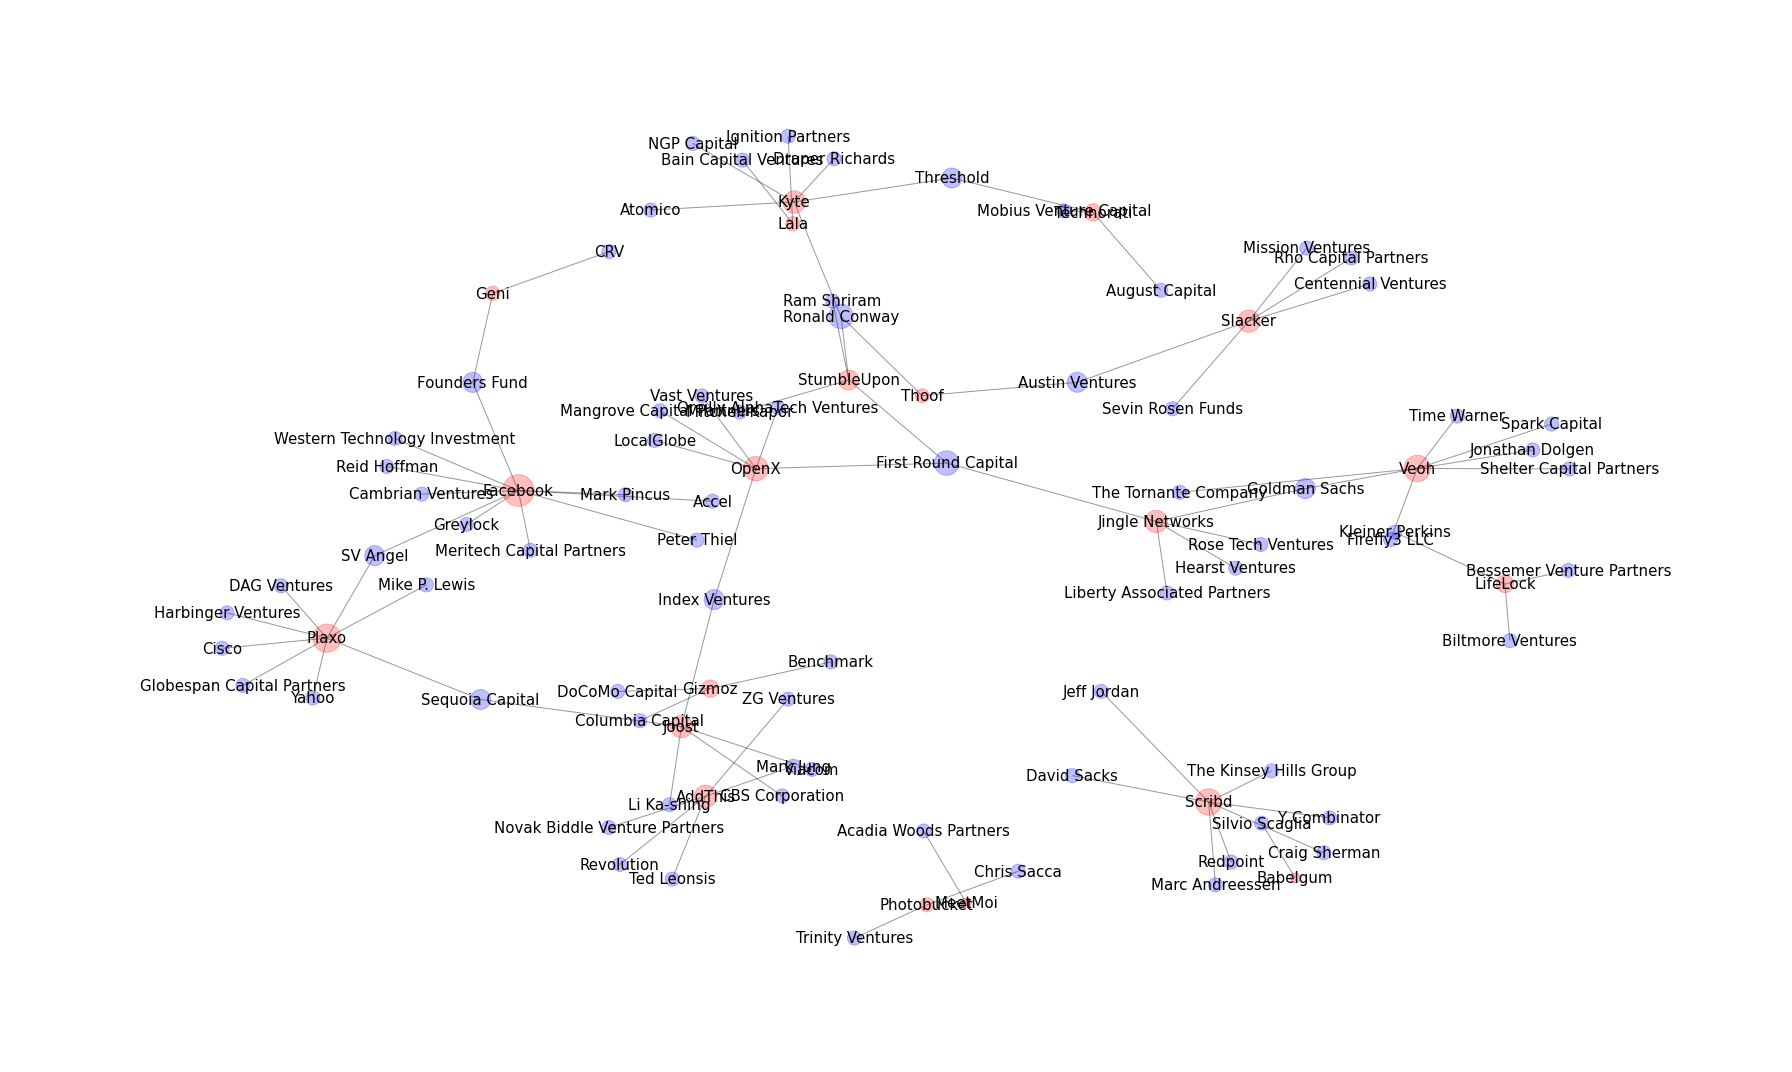

In [106]:
pos = plot_bipartite_graph(B, small_degree=True)

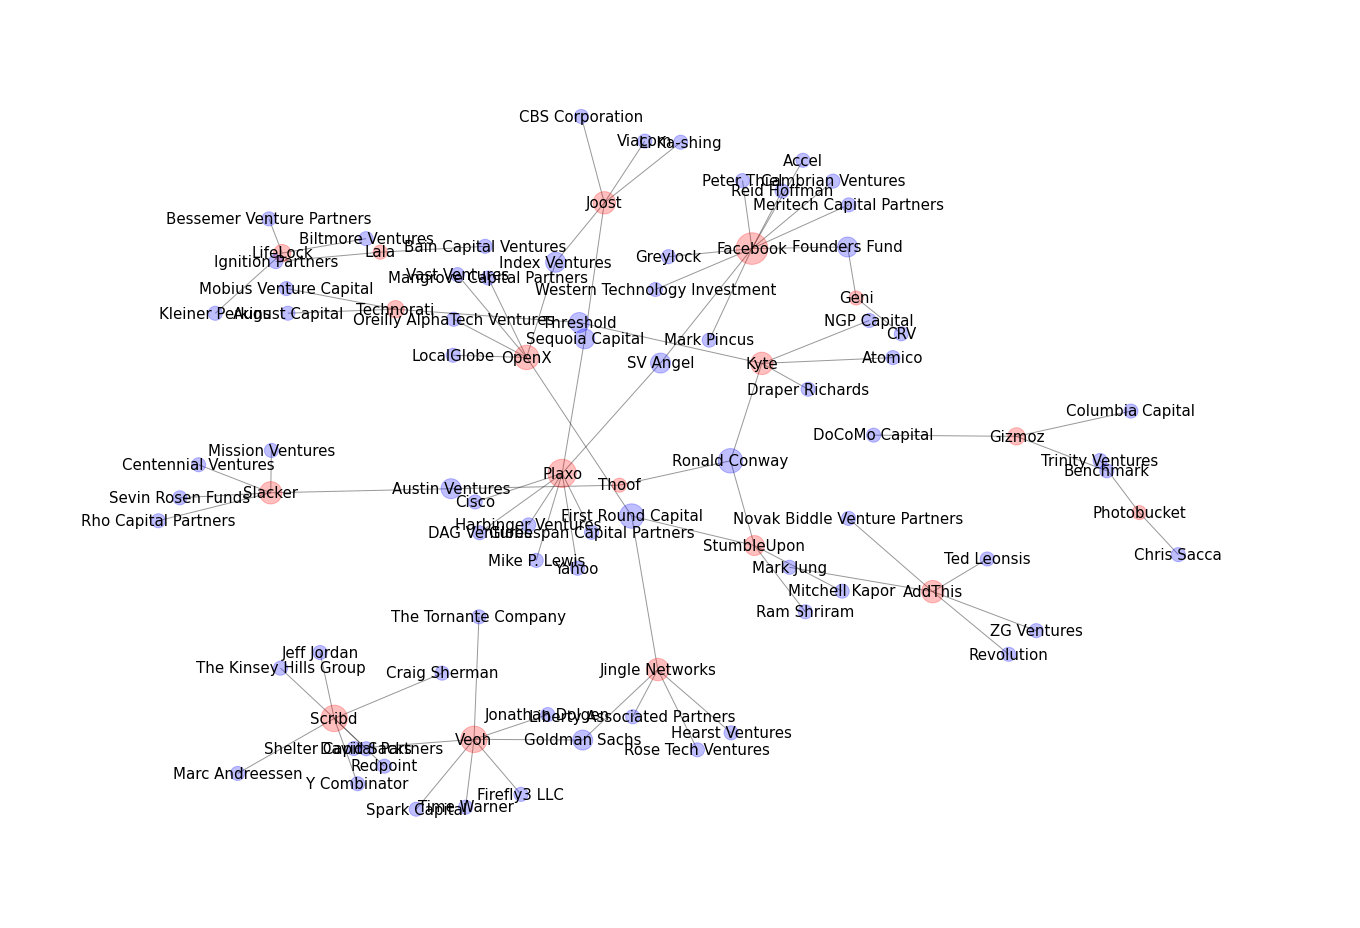

In [107]:
pos = plot_bipartite_graph(B, small_degree=False)

## Analysis <a class="anchor" id="analysis"></a>

In [108]:
df_essential = df_invest_funding[["org_name", "investor_name", "raised_amount_usd"]]
df_essential.head()

,org_name,investor_name,raised_amount_usd
0,Facebook,Peter Thiel,500000.0
1,Facebook,Reid Hoffman,500000.0
2,Facebook,Mark Pincus,500000.0
3,Facebook,Western Technology Investment,500000.0
4,Facebook,Accel,12700000.0


In [109]:
# delete value with NaN investments

df_essential.dropna(subset = ["raised_amount_usd"], inplace=True)

df_essential.head()

,org_name,investor_name,raised_amount_usd
0,Facebook,Peter Thiel,500000.0
1,Facebook,Reid Hoffman,500000.0
2,Facebook,Mark Pincus,500000.0
3,Facebook,Western Technology Investment,500000.0
4,Facebook,Accel,12700000.0


In [110]:
len(df_essential)

494133

In [111]:
# total amount of investments for each company

df_tot_inves_per_company = df_essential.groupby("org_name").sum()
df_tot_inves_per_company = df_tot_inves_per_company.sort_values("raised_amount_usd", ascending=False)
df_tot_inves_per_company.head()

,raised_amount_usd
org_name,
Broadcom Limited,8.000000e+11
Ant Group,1.580000e+11
Abu Dhabi National Oil Company,1.400000e+11
Uber,1.345116e+11
Didi,1.004617e+11


In [112]:
# total amount of investments for each investors

df_tot_inves_per_investor = df_essential.groupby("investor_name").sum()
df_tot_inves_per_investor = df_tot_inves_per_investor.sort_values("raised_amount_usd", ascending=False)
df_tot_inves_per_investor.head()

,raised_amount_usd
investor_name,
Silver Lake,1.627348e+11
Kohlberg Kravis Roberts,1.521948e+11
JP Morgan Chase,1.445013e+11
Tencent,1.381565e+11
Morgan Stanley,1.315562e+11


In [113]:
# number of investments for each company

df_num_inves_per_company = df_essential[["org_name", "investor_name"]].groupby("org_name").count()
df_num_inves_per_company = df_num_inves_per_company.sort_values("investor_name", ascending=False)
df_num_inves_per_company = df_num_inves_per_company.rename(columns={"investor_name":"number_inv_rounds"})
df_num_inves_per_company.head()

,number_inv_rounds
org_name,
Gusto,132
Uber,120
Dapper Labs,103
Lyft,100
Bolt,100


In [114]:
# number of investments for each investors

df_num_inves_per_investor = df_essential[["org_name", "investor_name"]].groupby("investor_name").count()
df_num_inves_per_investor = df_num_inves_per_investor.sort_values("org_name", ascending=False)
df_num_inves_per_investor = df_num_inves_per_investor.rename(columns={"org_name":"number_investments"})
df_num_inves_per_investor.head()

,number_investments
investor_name,
EASME - EU Executive Agency for SMEs,3672
Y Combinator,2563
Techstars,2027
New Enterprise Associates,1737
500 Startups,1609


## Update dictionaries  <a class="anchor" id="update"></a>

Please note that this step does not work if we haven't first run the main.ipynb file. ALso, remember that the filename is correct 

In [115]:
filename = "classes/dict_companies_cybersecurity_100.pickle"

with open(filename, 'rb') as f:
    dict_companies = pickle.load(f)

In [116]:
for name, c in dict_companies.items():
    
    # number previous investments
    if name in df_num_inves_per_company.index:
        num_previous_investments = df_num_inves_per_company.loc[name]['number_inv_rounds']
        
    # total amount previous investments
    if name in df_tot_inves_per_company.index:
        tot_previous_investments = df_tot_inves_per_company.loc[name]['raised_amount_usd']
        
    # update dict_companies
    dict_companies[name].num_previous_investments = num_previous_investments
    dict_companies[name].tot_previous_investments = tot_previous_investments

In [117]:
# save updated dictionary 

with open(filename, "wb") as f:
    pickle.dump(dict_companies, f)

In [118]:
dict_companies

{'OneTrust': Company(id='b99936db-3b9f-4397-e03b-7ddb70c2dc00', name='OneTrust', location={'country_code': 'USA', 'region': 'Georgia', 'city': 'Atlanta'}, lat=0, lon=0, degree=0, rank_CB=107.0, rank_algo=0, rank_analytic=0, tot_previous_investments=1940000000.0, num_previous_investments=8),
 'BigID': Company(id='655ff5a2-33d2-dfe5-af13-20866a58a5c0', name='BigID', location={'country_code': 'USA', 'region': 'New York', 'city': 'New York'}, lat=0, lon=0, degree=0, rank_CB=152.0, rank_algo=0, rank_analytic=0, tot_previous_investments=1358399996.0, num_previous_investments=35),
 'Zscaler': Company(id='3e9d5f7e-7301-b645-66af-eb756892af3a', name='Zscaler', location={'country_code': 'USA', 'region': 'California', 'city': 'San Jose'}, lat=0, lon=0, degree=0, rank_CB=170.0, rank_algo=0, rank_analytic=0, tot_previous_investments=368000000.0, num_previous_investments=4),
 'AppOmni': Company(id='7ca00768-e6a1-4a58-9aff-871a46bf8971', name='AppOmni', location={'country_code': 'USA', 'region': 'Cal

In [119]:
{name: row.tot_previous_investments for (name, row) in dict_companies.items()}

{'OneTrust': 1940000000.0,
 'BigID': 1358399996.0,
 'Zscaler': 368000000.0,
 'AppOmni': 339000000.0,
 'OPSWAT': 125000000.0,
 'Lacework': 5087000000.0,
 'Acronis': 430000000.0,
 'G4S': 1623000000.0,
 'Talend': 403240000.0,
 '1Password': 1600000000.0,
 'Telegram Messenger': 2000000000.0,
 'xMatters': 92750000.0,
 'Immuta': 1374300000.0,
 'NortonLifeLock': 1176000000.0,
 'FORT Robotics': 117000000.0,
 'Text IQ': 56400000.0,
 'BlueVoyant': 400500000.0,
 'x.ai': 301347996.0,
 'Synack': 1010900000.0,
 'FirstEnergy Corp.': 10000000000.0,
 'TripleBlind': 123000000.0,
 'StackPath': 828000000.0,
 'Signal Sciences': 274100000.0,
 'Secure Code Warrior': 247000000.0,
 'Edge': 9397542.0,
 'Fortanix': 39000000.0,
 'Inky': 89035000.0,
 'Saab': 20241788.0,
 'MeWe': 20241788.0,
 'Dtex Systems': 107534904.0,
 'Numbers Protocol': 1320000.0,
 'Armor': 111000000.0,
 'Platform.sh': 215200000.0,
 'True-Tickets': 215200000.0,
 'Threatcare': 16236000.0,
 'Noname Security': 75000000.0,
 'Alcide': 31400000.0,
 '